In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Input,Embedding, SimpleRNN, Dense, Dropout,LSTM,Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from google.colab import drive
import pickle

In [ ]:
import pandas as pd
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/BanglaMedia.csv'
data = pd.read_csv(file_path)
data.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Comments,Topic,Sentiment
0,12/27/2024,আমার এলাকায় বনশ্রীতে খবর বেশি একটা ভালো না,others,negative
1,12/24/2024,৬৫ পদের মশলা দেখছে ও একসাথে! বিশ্ব চাপাবাজ! আম...,food,negative
2,12/11/2024,ফাহিম ভাইয়ের ব্লগ আমার ঘরনি পছন্দ করে,others,positive
3,12/17/2024,বাচ্চাদের সাথে আপনার ব্যবহার খুব সুন্দর লাগলো,others,positive
4,12/12/2024,মাংসে সর্বোচ্চ ৩০ প্রকারের মসলা যেটা ব্যবহার ...,food,negative


In [ ]:
# number k string a convert kora
data['Comments'] = data['Comments'].astype(str)

In [ ]:

#text to word convert
tokenizer = Tokenizer(num_words=3000, oov_token="<nothing>")# if unkonw word assign nothing special tk
tokenizer.fit_on_texts(data['Comments'])# assign number for every word
sequences = tokenizer.texts_to_sequences(data['Comments'])
# sequences


In [ ]:
print(sequences[:1])    # first 5 sequences দেখাবে


[[29, 1, 1, 92, 94, 20, 8, 2]]


In [ ]:
for comment, seq in list(zip(data['Comments'], sequences))[:1]:
    print(seq, " --> ", comment)


[29, 1, 1, 92, 94, 20, 8, 2]  -->  আমার এলাকায় বনশ্রীতে খবর বেশি একটা ভালো না


In [ ]:
# Unique word commentes
len(tokenizer.word_index)

16165

In [ ]:
for word, index in list(tokenizer.word_index.items())[:10]:
    print(f"{word}: {index}")

<nothing>: 1
না: 2
করে: 3
কি: 4
এই: 5
হবে: 6
আর: 7
ভালো: 8
কে: 9
বাংলাদেশ: 10


In [ ]:
# padding korte hb karon martix golo k same size ante hb
sequences = pad_sequences(sequences,padding='post')
sequences

array([[  29,    1,    1, ...,    0,    0,    0],
       [1246, 2036, 1382, ...,    0,    0,    0],
       [ 553, 1535, 1128, ...,    0,    0,    0],
       ...,
       [   1,  298,    8, ...,    0,    0,    0],
       [   5,  130, 2765, ...,    0,    0,    0],
       [   1,    1,   49, ...,    0,    0,    0]], dtype=int32)

In [ ]:
voccabulary_size = len(tokenizer.word_index) + 1;

In [ ]:
#data train section
from sklearn.model_selection import train_test_split
X = sequences


**Senitment Analysis**

In [ ]:
# je he tu sentiment number a nai tahola aga number dea prokash korta hb tai endcode korta hb as a matrix
# sentiment label ar jonno


le_sentiment = LabelEncoder()
data['label_Sentiment'] = le_sentiment.fit_transform(data['Sentiment'])

print(list(le_sentiment.classes_))
print(len(le_sentiment.classes_))


['hate', 'negative', 'neutral', 'positive']
4


In [ ]:
# sentiment data
y = data['label_Sentiment'];
# model train amd test 0.2 mane 20% test a rake 80% trainning dea
X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size=0.2 )
# model train and validation train korar sate sate validation kora tik kora kaj korta se kinah improment check
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2)

In [ ]:

print("Train  shape:", len(X_train), len(y_train))
print("Validotion  shape:", len(X_val), len(y_val))
print("Test  shape:", len(X_test), len(y_test))



Train  shape: 4944 4944
Validotion  shape: 1236 1236
Test  shape: 1545 1545


In [ ]:
embedding_dim = 100;
rnnUnits = 128 # 100 neurons

In [ ]:
Inputlength = X_train.shape[1];
model = Sequential([
     Embedding(input_dim=voccabulary_size, output_dim=embedding_dim,input_length=Inputlength),
     SimpleRNN(rnnUnits, activation='tanh', return_sequences=False),
     Dropout(0.3),
     Dense(32, activation='relu'),
     Dropout(0.3),
     Dense(len(le_sentiment.classes_), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',

    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# sentiment
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.3471 - loss: 1.4891 - val_accuracy: 0.4417 - val_loss: 1.2950
Epoch 2/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.4321 - loss: 1.3277 - val_accuracy: 0.4482 - val_loss: 1.5326
Epoch 3/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.4189 - loss: 1.3734 - val_accuracy: 0.4490 - val_loss: 1.2644
Epoch 4/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.4471 - loss: 1.2891 - val_accuracy: 0.4482 - val_loss: 1.2738
Epoch 5/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.4346 - loss: 1.2867 - val_accuracy: 0.4482 - val_loss: 1.2689
Restoring model weights from the end of the best epoch: 3.


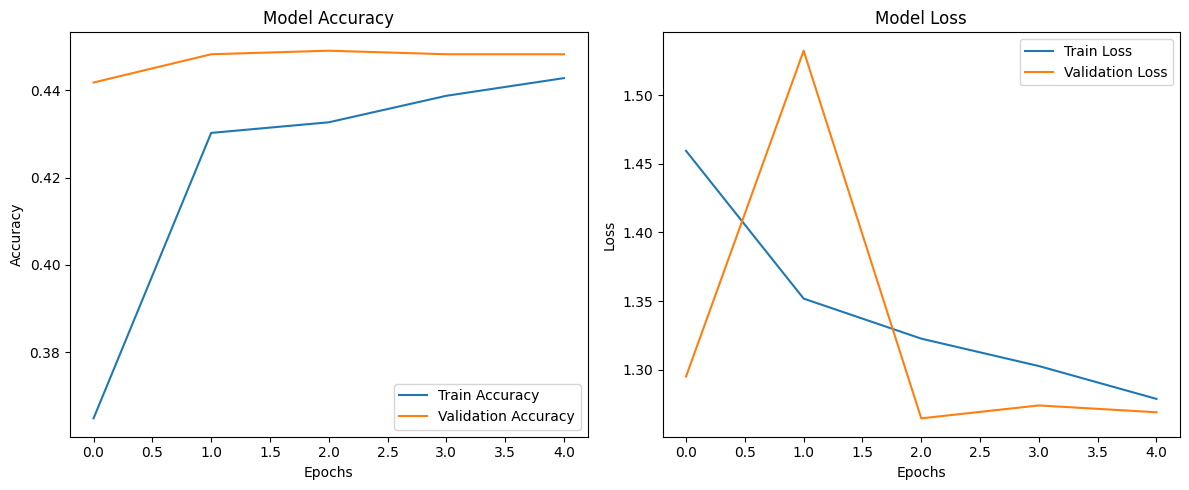

In [ ]:

h = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(h['accuracy'], label='Train Accuracy')
plt.plot(h['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h['loss'], label='Train Loss')
plt.plot(h['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
print(cm)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
[[  0 177   0   0]
 [  0 699   0   0]
 [  0 373   2   0]
 [  0 294   0   0]]


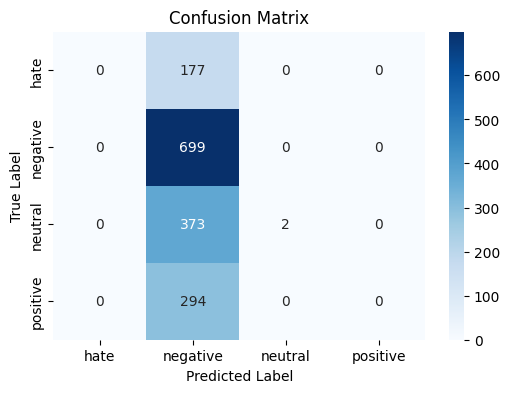

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=le_sentiment.classes_,
yticklabels=le_sentiment.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Using LSTM**

In [ ]:
Inputlength = X_train.shape[1];
embedding_dim = 100;
Unit = 128;
sentiment_model_lstm = Sequential([
    Embedding(input_dim=voccabulary_size, output_dim=embedding_dim, input_length=Inputlength),
    Bidirectional(LSTM(Unit, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(le_sentiment.classes_), activation='softmax') # Assuming 4 classes for sentiment
])

sentiment_model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history_sentiment_lstm = sentiment_model_lstm.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 399ms/step - accuracy: 0.4359 - loss: 1.2831 - val_accuracy: 0.5170 - val_loss: 1.1715
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 382ms/step - accuracy: 0.5440 - loss: 1.0840 - val_accuracy: 0.5850 - val_loss: 1.0088
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 382ms/step - accuracy: 0.6310 - loss: 0.9106 - val_accuracy: 0.5987 - val_loss: 0.9382
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.7367 - loss: 0.6888 - val_accuracy: 0.6084 - val_loss: 0.9730
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 385ms/step - accuracy: 0.7947 - loss: 0.5452 - val_accuracy: 0.6319 - val_loss: 1.0123
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 377ms/step - accuracy: 0.8353 - loss: 0.4693 - val_accuracy: 0.6254 - val_loss: 1.0799
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


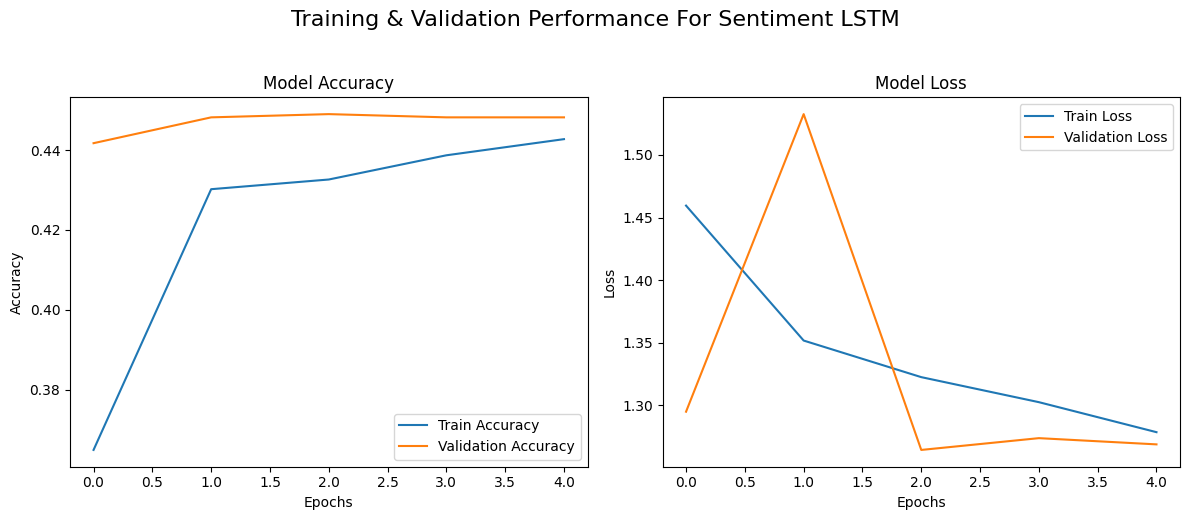

In [ ]:
h = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(h['accuracy'], label='Train Accuracy')
plt.plot(h['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h['loss'], label='Train Loss')
plt.plot(h['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.suptitle("Training & Validation Performance For Sentiment LSTM", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

**Topic Classification**

In [ ]:
# topic label ar jonno
le_topic= LabelEncoder()

data['label_Topic'] = le_topic.fit_transform(data['Topic'])

print(list(le_topic.classes_))
print(len(le_topic.classes_))

['abusive', 'education', 'food', 'international', 'others', 'political', 'religious', 'sports', 'technology', 'threat']
10


In [ ]:
# Topic data
z = data['label_Topic'];
X_train, X_test, z_train, z_test = train_test_split(sequences, z, test_size=0.2 )
X_train, X_val, z_train, z_val = train_test_split( X_train, z_train, test_size=0.2)

In [ ]:
print("Train  shape:", len(X_train), len(z_train))
print("Validotion  shape:", len(X_val), len(z_val))
print("Test  shape:", len(X_test), len(z_test))

Train  shape: 4944 4944
Validotion  shape: 1236 1236
Test  shape: 1545 1545


In [ ]:
embedding_dim = 100;
rnnUnits = 128 # 100 neurons
Inputlength = X_train.shape[1];
model = Sequential([
     Embedding(input_dim=voccabulary_size, output_dim=embedding_dim,input_length=Inputlength),
     SimpleRNN(rnnUnits, activation='tanh', return_sequences=False),
     Dropout(0.3),
     Dense(32, activation='relu'),
     Dropout(0.3),
     Dense(len(le_topic.classes_), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)



In [ ]:
# topic
history = model.fit(
    X_train, z_train,
    validation_data=(X_val, z_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.2351 - loss: 2.1559 - val_accuracy: 0.3374 - val_loss: 2.0000
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3347 - loss: 2.0390 - val_accuracy: 0.3374 - val_loss: 1.9949
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3646 - loss: 1.9852 - val_accuracy: 0.3374 - val_loss: 1.9839
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3520 - loss: 1.9856 - val_accuracy: 0.3374 - val_loss: 1.9872
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3508 - loss: 1.9843 - val_accuracy: 0.3374 - val_loss: 1.9874


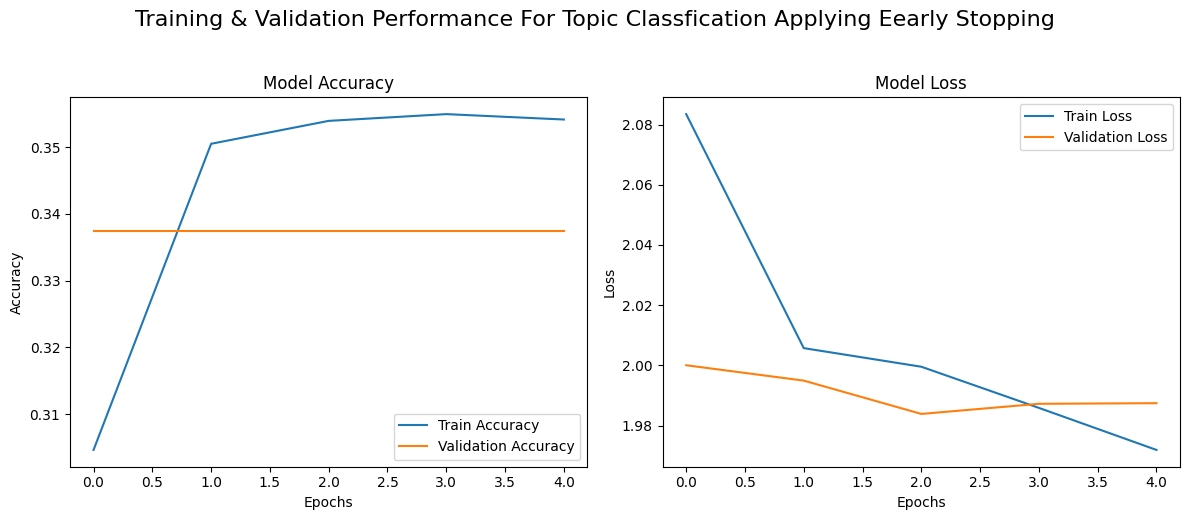

In [ ]:
h = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(h['accuracy'], label='Train Accuracy')
plt.plot(h['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h['loss'], label='Train Loss')
plt.plot(h['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.suptitle("Training & Validation Performance For Topic Classfication Applying Eearly Stopping", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(z_test, y_pred)

print(cm)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[  0   0   0   0 171   0   0   0   0   0]
 [  0   0   0   0  81   0   0   0   0   0]
 [  0   0   0   0  92   0   0   0   0   0]
 [  0   0   0   0 173   0   0   0   0   0]
 [  0   0   0   0 561   0   0   0   0   0]
 [  0   0   0   0 177   0   0   0   0   0]
 [  0   0   0   0 135   0   0   0   0   0]
 [  0   0   0   0  89   0   0   0   0   0]
 [  0   0   0   0  51   0   0   0   0   0]
 [  0   0   0   0  15   0   0   0   0   0]]


<function matplotlib.pyplot.show(close=None, block=None)>

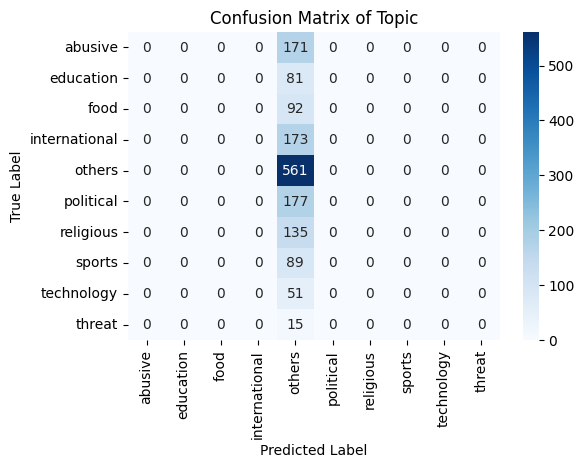

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=le_topic.classes_,
yticklabels=le_topic.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Topic")
plt.show

**LSTM Topic**

In [ ]:
Inputlength = X_train.shape[1];
embedding_dim = 50;
Unit = 128;
topic_model_lstm = Sequential([
    Embedding(input_dim=voccabulary_size, output_dim=embedding_dim, input_length=Inputlength),
    Bidirectional(LSTM(Unit, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(le_topic.classes_), activation='softmax') # Assuming 4 classes for sentiment
])

topic_model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history_topic_lstm = topic_model_lstm.fit(
        X_train, z_train,
        validation_data=(X_val, z_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 386ms/step - accuracy: 0.3380 - loss: 2.0421 - val_accuracy: 0.3503 - val_loss: 1.9380
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 374ms/step - accuracy: 0.3928 - loss: 1.8170 - val_accuracy: 0.4361 - val_loss: 1.7021
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 385ms/step - accuracy: 0.4753 - loss: 1.5282 - val_accuracy: 0.4749 - val_loss: 1.6020
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 381ms/step - accuracy: 0.6086 - loss: 1.1894 - val_accuracy: 0.5485 - val_loss: 1.4444
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - accuracy: 0.7473 - loss: 0.8632 - val_accuracy: 0.5785 - val_loss: 1.4313
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 32s 404ms/step - accuracy: 0.7982 - loss: 0.6942 - val_accuracy: 0.5866 - val_loss: 1.5053
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 374ms/step - accuracy: 0.8264 - loss: 0.5999 - val_accuracy: 0.5769 - val_loss: 1.5298


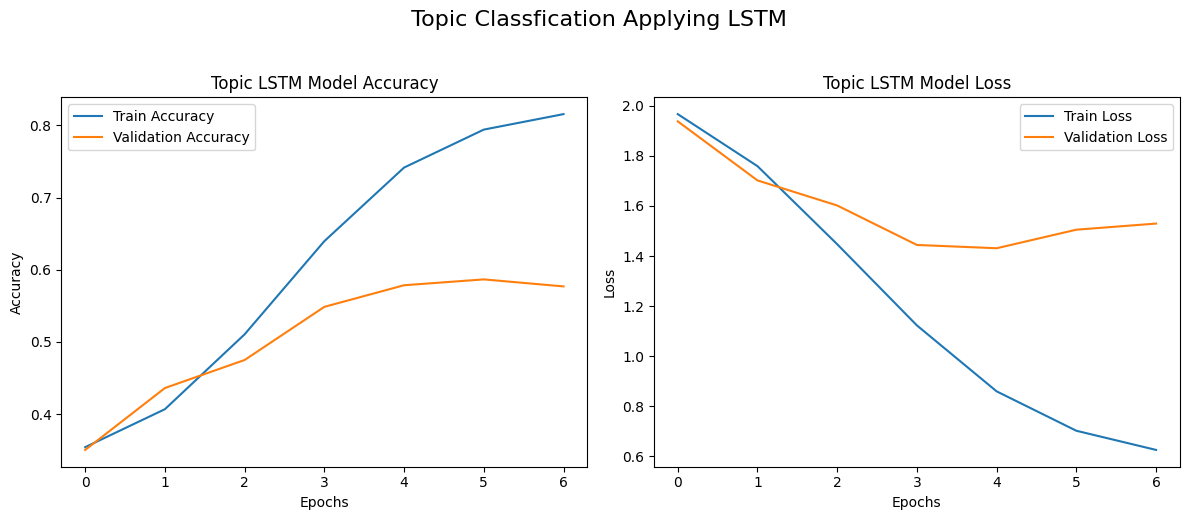

In [ ]:
h = history_topic_lstm.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(h['accuracy'], label='Train Accuracy')
plt.plot(h['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Topic LSTM Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h['loss'], label='Train Loss')
plt.plot(h['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Topic LSTM Model Loss')
plt.legend()

plt.suptitle(" Topic Classfication Applying LSTM", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

Model Evaluation


In [ ]:
from sklearn.metrics import classification_report
rnn_pred = model.predict(X_test).argmax(axis=1)
lstm_pred = topic_model_lstm.predict(X_test).argmax(axis=1)

print("\nRNN CLASSIFICATION REPORT")
print(classification_report(z_test, rnn_pred,
target_names=list(le_topic.classes_)))

print("\nLSTM CLASSIFICATION REPORT")
print(classification_report(z_test, lstm_pred,
target_names=list(le_topic.classes_)))

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step

RNN CLASSIFICATION REPORT
               precision    recall  f1-score   support

      abusive       0.00      0.00      0.00       171
    education       0.00      0.00      0.00        81
         food       0.00      0.00      0.00        92
international       0.00      0.00      0.00       173
       others       0.36      1.00      0.53       561
    political       0.00      0.00      0.00       177
    religious       0.00      0.00      0.00       135
       sports       0.00      0.00      0.00        89
   technology       0.00      0.00      0.00        51
       threat       0.00      0.00      0.00        15

     accuracy                           0.36      1545
    macro avg       0.04      0.10      0.05      1545
 weighted avg       0.13      0.36      0.19      1545


LSTM CLASSIFICATION REPORT
               precision    recall  f1-score   support

      abusive       0.50      0.50   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Comparison

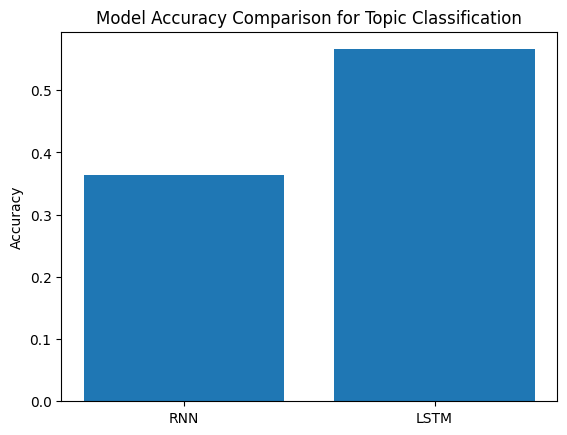

In [ ]:
rnn_acc = model.evaluate(X_test, z_test, verbose=0)[1]
lstm_acc = topic_model_lstm.evaluate(X_test, z_test, verbose=0)[1]

plt.bar(["RNN","LSTM"], [rnn_acc, lstm_acc])
plt.title("Model Accuracy Comparison for Topic Classification")
plt.ylabel("Accuracy")
plt.show()

**Topic Prediction**


In [ ]:

topic_model_lstm.save("final_lstm_topic_model.h5")

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('le_topic.pkl', 'wb') as f:
    pickle.dump(le_topic, f)

model_topic_loaded = load_model("final_lstm_topic_model.h5")

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("le_topic.pkl", "rb") as f:
    le_topic = pickle.load(f)


Inputlength = X_train.shape[1]


def predict_comment(text):
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=Inputlength, padding='post')

    pred = model_topic_loaded.predict(seq)
    label = np.argmax(pred)
    final_output = le_topic.inverse_transform([label])

    return final_output[0]






**Sentiment Prediction**

In [ ]:
sentiment_model_lstm.save("final_lstm_sentiment_model.h5")

import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("le_sentiment.pkl", "wb") as f:
    pickle.dump(le_sentiment, f)



# Load model
model_sentiment_loaded = load_model("final_lstm_sentiment_model.h5")

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer_loaded = pickle.load(f)

# Load label encoder
with open("le_sentiment.pkl", "rb") as f:
    le_sentiment_loaded = pickle.load(f)

Inputlength_sentiment_loaded = X_train.shape[1]

def predict_sentiment(text):
    seq = tokenizer_loaded.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=Inputlength_sentiment_loaded, padding='post')

    pred = model_sentiment_loaded.predict(seq)
    label = np.argmax(pred)
    return le_sentiment_loaded.inverse_transform([label])[0]




user_text = input("Write a comment: ")

result1 = predict_comment(user_text)

print("Predicted Topic:", result1)

result = predict_sentiment(user_text)

print("Predicted Sentiment:", result)

Write a comment: বাচ্চাদের সাথে আপনার ব্যবহার খুব সুন্দর লাগলো
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicted Topic: others
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicted Sentiment: positive
